## 第一模块  数据准备

In [1]:
import pandas as pd
import numpy as np
import time
import datetime
import statsmodels.api as sm
import pickle
import warnings
from jqdata import *
warnings.filterwarnings('ignore')

## 常量定义

In [2]:
start_date = '2018-01-01'
end_date = '2020-07-01'


all_trade_days = (get_trade_days(start_date=start_date,end_date=end_date)).tolist() #所有交易日
trade_days = all_trade_days[::20] #每隔20天取一次数据，基本面数据更新频率较慢，数据获取频率尽量与之对应

securities = get_all_securities()  # 获取全市场股票代码
all_stocks = list(securities.index)

INDUSTRY_NAME = 'sw_l1'

ttm_factors = []

In [3]:
fac_dict = {   
            'MC':valuation.market_cap, # 总市值
            'INC':indicator.inc_return, # 净资产收益率(扣除非经常损益)(%)
            'GPM':indicator.gross_profit_margin, # 毛利率
            'ITRYOY':indicator.inc_total_revenue_year_on_year}

factor_list = list(fac_dict.keys())

## 定义获取基本面信息的函数接口

In [4]:
def get_fundamental_data(securities, factor_list, ttm_factors, date):
    '''
    获取基本面数据,横截面数据，时间、股票、因子三个参数确定
    获取的数据中含有Nan值，一般用行业均值填充
    输入：
    securities：list,查询的股票
    factor_list:list, 普通因子
    ttm_factors:list, ttm因子，获取过去四个季度财报数据的和
    date:str 或者 datetime.data, 获取数据的时间
    输出：
    DataFrame,普通因子和ttm因子的合并，index为股票代码，values为因子值
    '''
    if len(factor_list) == 0:
        return 'factors list is empty, please input data'
    #获取查询的factor list
    q = query(valuation.code)
    for fac in factor_list:
        q = q.add_column(fac_dict[fac])
    q = q.filter(valuation.code.in_(securities))
    fundamental_df = get_fundamentals(q,date)
    fundamental_df.index = fundamental_df['code']
    fundamental_df.columns = ['code'] + factor_list

    if type(date) == str:
        year = int(date[:4])
        month_day = date[5:]
    elif type(date) == datetime.date:
        date = date.strftime('%Y-%m-%d')
        year = int(date[:4])
        month_day = date[5:]
    else:
        return 'input date error'
    
    if month_day < '05-01':
        statdate_list = [str(year-2)+'q4', str(year-1)+'q1', str(year-1)+'q2', str(year-1)+'q3']
    elif month_day >= '05-01' and month_day < '09-01':
        statdate_list = [str(year-1)+'q1', str(year-1)+'q2', str(year-1)+'q3',str(year)+'q1']
    elif month_day >= '09-01' and month_day < '11-01':
        statdate_list = [str(year-1)+'q2', str(year-1)+'q3', str(year)+'q1', str(year)+'q2']
    elif month_day >= '11-01':
        statdate_list = [str(year-1)+'q4', str(year)+'q1', str(year)+'q2', str(year)+'q3']
            
    ttm_fundamental_data = ''
   
    ttm_q = query(valuation.code)
    for fac in ttm_factors:
        ttm_q = ttm_q.add_column(fac_dict[fac])
    ttm_q = ttm_q.filter(valuation.code.in_(securities))  
                             
    for statdate in statdate_list:
        if type(ttm_fundamental_data) == str:
            fundamental_data = get_fundamentals(ttm_q, statDate=statdate)
            fundamental_data.index = fundamental_data['code']
            ttm_fundamental_data = fundamental_data
        else:
            fundamental_data = get_fundamentals(ttm_q, statDate=statdate)
            fundamental_data.index = fundamental_data['code']
            ttm_fundamental_data.iloc[:,1:] += fundamental_data.iloc[:,1:]
    ttm_fundamental_data.columns = ['code'] + ttm_factors
    results = pd.merge(fundamental_df,ttm_fundamental_data,on=['code'],how='inner')
    results = results.sort_values(by='code')
    results.index = results['code']
    results = results.drop(['code'],axis=1)
    #删除非数值列
    columns = list(results.columns)
    for column in columns:
        if not(isinstance(results[column][0],int) or isinstance(results[column][0],float)):
            results = results.drop([column],axis=1)
    return results

## 定义获取股票行业信息

In [5]:
def get_stock_industry(industry_name,date,output_csv = False):
    '''
    获取股票对应的行业
    input：
    industry_name: str, 
    "sw_l1": 申万一级行业
    "sw_l2": 申万二级行业
    "sw_l3": 申万三级行业
    "jq_l1": 聚宽一级行业
    "jq_l2": 聚宽二级行业
    "zjw": 证监会行业
    date:时间
    output: DataFrame,index 为股票代码，columns 为所属行业代码
    '''
    industries = list(get_industries(industry_name).index)
    all_securities = get_all_securities(date=date)   #获取当天所有股票代码
    all_securities['industry_code'] = 1
    for ind in industries:
        industry_stocks = get_industry_stocks(ind,date)
        #有的行业股票不在all_stocks列表之中
        industry_stocks = set(all_securities) & set(industry_stocks)
        all_securities['industry_code'][industry_stocks] = ind
    stock_industry = all_securities['industry_code'].to_frame()
    if output_csv == True:
        stock_industry.to_csv('stock_industry.csv') #输出csv文件，股票对应行业
    return stock_industry


def fillna_with_industry(data,date,industry_name='sw_l1'):
    '''
    使用行业均值填充nan值
    input:
    data：DataFrame,输入数据，index为股票代码
    date:string,时间必须和data数值对应时间一致
    output：
    DataFrame,缺失值用行业中值填充，无行业数据的用列均值填充
    '''
    stocks = list(data.index)
    stocks_industry = get_stock_industry(industry_name,date)
    stocks_industry_merge = data.merge(stocks_industry, left_index=True,right_index=True,how='left')
    stocks_dropna = stocks_industry_merge.dropna()
    columns = list(data.columns)
    select_data = []
    group_data = stocks_industry_merge.groupby('industry_code')
    group_data_mean = group_data.mean()
    group_data = stocks_industry_merge.merge(group_data_mean,left_on='industry_code',right_index=True,how='left')
    for column in columns:

        if type(data[column][0]) != str:

            group_data[column+'_x'][pd.isnull(group_data[column+'_x'])] = group_data[column+'_y'][pd.isnull(group_data[column+'_x'])]
            
            group_data[column] = group_data[column+'_x']
            #print(group_data.head())
            select_data.append(group_data[column])
            
    result = pd.concat(select_data,axis=1)
    #行业均值为Nan,用总体均值填充
    mean = result.mean()
    for i in result.columns:
        result[i].fillna(mean[i],inplace=True)
    return result

In [6]:
#获取日期列表
def get_tradeday_list(start,end,frequency=None,count=None):
    '''
    input:
    start:str or datetime,起始时间，与count二选一
    end:str or datetime，终止时间
    frequency:
        str: day,month,quarter,halfyear,默认为day
        int:间隔天数
    count:int,与start二选一，默认使用start
    '''
    if isinstance(frequency,int):
        all_trade_days = get_trade_days(start,end)
        trade_days = all_trade_days[::frequency]
        days = [datetime.datetime.strftime(i,'%Y-%m-%d') for i in trade_days]
        return days
    
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        days = df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            days = df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='04') | (df['month']=='07') | (df['month']=='10') ]
            days = df.drop_duplicates('year-month').index
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='06')]
            days = df.drop_duplicates('year-month').index
    trade_days = [datetime.datetime.strftime(i,'%Y-%m-%d') for i in days]
    return trade_days
tl = get_tradeday_list(start_date,end_date,frequency='month')

##  数据处理算法

In [7]:
#去极值函数
#mad中位数去极值法
def filter_extreme_MAD(series,n): #MAD: 中位数去极值 
    median = series.quantile(0.5)
    new_median = ((series - median).abs()).quantile(0.50)
    max_range = median + n*new_median
    min_range = median - n*new_median
    return np.clip(series,min_range,max_range)


#进行标准化处理
def winsorize(factor, std=3, have_negative = True):
    '''
    去极值函数 
    factor:以股票code为index，因子值为value的Series
    std为几倍的标准差，have_negative 为布尔值，是否包括负值
    输出Series
    '''
    r=factor.dropna().copy()
    if have_negative == False:
        r = r[r>=0]
    else:
        pass
    #取极值
    edge_up = r.mean()+std*r.std()
    edge_low = r.mean()-std*r.std()
    r[r>edge_up] = edge_up
    r[r<edge_low] = edge_low
    return r


#标准化函数：
def standardize(s,ty=2):
    '''
    s为Series数据
    ty为标准化类型:1 MinMax,2 Standard,3 maxabs 
    '''
    data=s.dropna().copy()
    if int(ty)==1:
        re = (data - data.min())/(data.max() - data.min())
    elif ty==2:
        re = (data - data.mean())/data.std()
    elif ty==3:
        re = data/10**np.ceil(np.log10(data.abs().max()))
    return re


#数据去极值及标准化
def winsorize_and_standarlize(data,qrange=[0.05,0.95],axis=0):
    '''
    input:
    data:Dataframe or series,输入数据
    qrange:list,list[0]下分位数，list[1]，上分位数，极值用分位数代替
    '''
    if isinstance(data,pd.DataFrame):
        if axis == 0:
            q_down = data.quantile(qrange[0])
            q_up = data.quantile(qrange[1])
            index = data.index
            col = data.columns
            for n in col:
                data[n][data[n] > q_up[n]] = q_up[n]
                data[n][data[n] < q_down[n]] = q_down[n]
            data = (data - data.mean())/data.std()
            data = data.fillna(0)
        else:
            data = data.stack()
            data = data.unstack(0)
            q = data.quantile(qrange)
            index = data.index
            col = data.columns
            for n in col:
                data[n][data[n] > q[n]] = q[n]
            data = (data - data.mean())/data.std()
            data = data.stack().unstack(0)
            data = data.fillna(0)
            
    elif isinstance(data,pd.Series):
        name = data.name
        q = data.quantile(qrange)
        data = np.clip(data,q.values[0],q.values[1])
        data = (data - data.mean())/data.std()
    return data
    

def neutralize(data,date,market_cap,industry_name='sw_l1'):
    '''
    中性化，使用行业和市值因子中性化
    input：
    data：DataFrame,index为股票代码，columns为因子，values为因子值
    name:str,行业代码
    "sw_l1": 申万一级行业
    "sw_l2": 申万二级行业
    "sw_l3": 申万三级行业
    "jq_l1": 聚宽一级行业
    "jq_l2": 聚宽二级行业
    "zjw": 证监会行业
    date:获取行业数据的时间
    maket_cap:市值因子
    '''
    industry_se = get_stock_industry(industry_name,date)
    columns = list(data.columns)
    if isinstance(industry_se,pd.Series):
        industry_se = industry_se.to_frame()
    if isinstance(market_cap,pd.Series):
        market_cap = market_cap.to_frame()
        
    index = list(data.index)
    industry_se = np.array(industry_se.ix[index,0].tolist())
    industry_dummy = sm.categorical(industry_se,drop=True)
    industry_dummy = pd.DataFrame(industry_dummy,index=index)
    market_cap = np.log(market_cap.loc[index])
    x = pd.concat([industry_dummy,market_cap],axis=1)
    model = sm.OLS(data,x)
    result = model.fit()
    y_fitted =  result.fittedvalues
    neu_result = data - y_fitted
    return neu_result

## 计算月度收益

In [8]:
def get_month_profit(stocks,start_date,end_date,month_num=1,cal_num=3):
    '''
    获取月收益率数据，数据为本月相对于上月的增长率
    input:
    stocks:list 股票代码
    start_date:str, 初始日期
    end_date:str,终止日期
    month_num:计算几个月的收益率，默认为1，即一个月的收益率
    cal_num:int，计算每月最后n天的收盘价均值，默认为3
    
    '''
    start_year = int(start_date[:4])
    end_year = int(end_date[:4])
    start_month = int(start_date[5:7])
    end_month = int(end_date[5:7])
    len_month = (end_year - start_year)*12 + (end_month - start_month)
    price_list = []
    #获取初始时间之前一个月的价格数据
    if start_month == 1:
        last_date = str(start_year-1)+'-'+'12'+'-'+'01'
    else:
        last_date = str(start_year-1)+'-'+str(start_month-1)+'-'+'01'
    last_price = get_price(stocks,fields=['close'],count=cal_num,end_date=last_date)['close']
    last_price = last_price.mean().to_frame()
    last_price.columns = [last_date]
    price_list.append(last_price)
    #计算给定时间段内的月度价格数据
    for i in range(len_month):
        date = str(start_year+i//12)+'-'+str(start_month+i%12)+'-'+'01'
        price = get_price(stocks,fields=['close'],count=cal_num,end_date=date)['close']
        price_mean = price.mean().to_frame()
        price_mean.columns = [date]
        price_list.append(price_mean)
    month_profit = pd.concat(price_list,axis=1)
    #计算月度收益率
    month_profit_pct = month_profit.pct_change(month_num,axis=1).dropna(axis=1,how='all')
    return month_profit_pct


def get_profit_depend_timelist(stocks,timelist,month_num=1,cal_num=3):
    '''
    input:
    stocks:list 股票代码
    timelist: 时间序列
    month_num:计算几个月的收益率，默认为1，即一个月的收益率
    cal_num:int，计算每月最后n天的收盘价均值，默认为3
    '''
    price_list = []
    for date in timelist:
        price = get_price(stocks, fields=['close'], count=cal_num, end_date=date)['close']
        price_mean = price.mean().to_frame()
        price_mean.columns = [date]
        price_list.append(price_mean)
    profit = pd.concat(price_list,axis=1)
    profit_pct = profit.pct_change(month_num,axis=1).dropna(axis=1,how='all')
    return profit_pct





## 获取某一天的基本面数据

In [9]:
def get_one_day_data(stocks,factor_list,ttm_factors,date,neu=False):
    '''
    获取一天的基本面数据
    input:
    stocks:list,股票列表
    factor_list:list,普通因子列表
    ttm_factors:list,ttm因子列表
    date:str or datetime， 获取数据时间
    neu:bool,是否进行中性化处理，使用市值和行业进行中性化，默认不进行中性化
    '''
    fund_data = get_fundamental_data(stocks,factor_list,ttm_factors,date)
    fillna_data = fillna_with_industry(fund_data,date)
    if neu == False:
        results = winsorize_and_standarlize(fillna_data)
    elif 'MC' in fillna_data.columns:
        neu_data = neutralize(fillna_data,date,fillna_data['MC'])
        results = winsorize_and_standarlize(neu_data)
    elif 'market_cap' in fillna_data.columns:
        neu_data = neutralize(fillna_data,date,fillna_data['market_cap'])
        results = winsorize_and_standarlize(neu_data)
    else:
        print("error: please input 'market_cap' for neutralize")
        return None
    return results

In [10]:
def get_timelist_data(stocks,factor_list,ttm_factors,timelist,neu=False):
    """
    获取一段时间的基本面数据
    stocks： list，证券名称列表
    factor_list： list， 因子名称
    ttm_factors： list， ttm因子名称
    timelist： list，日期列表
    neu： 是否做中性化处理
    """
    dic = {}
    for date in timelist:
        fund_date = get_one_day_data(stocks,factor_list,ttm_factors,date,neu=neu)
        dic[date] = fund_date
    return dic


## 获取需要计算的数据

In [11]:
fund_data = get_timelist_data(all_stocks,factor_list,ttm_factors,tl)
fund_data_neu = get_timelist_data(all_stocks,factor_list,ttm_factors,tl,neu=True)
profit =  get_profit_depend_timelist(all_stocks,tl,month_num=1,cal_num=3)
res = []
res.append(fund_data)
res.append(fund_data_neu)
res.append(profit)


In [12]:
with open("res_data.pkl", 'wb+') as file:
    pickle.dump(res, file)

## 导入其他相关库包

In [13]:
import statsmodels.api as sm
import warnings
from sklearn.feature_selection import RFE, SelectKBest,SelectPercentile, SelectFromModel, f_classif
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import gc
from sklearn.metrics import accuracy_score, recall_score

In [14]:
fund_data = res[0]
fund_data_neu = res[1]
profit = res[2]

In [15]:
profit.head()

,2018-02-01,2018-03-01,2018-04-02,2018-05-02,2018-06-01,2018-07-02,2018-08-01,2018-09-03,2018-10-08,2018-11-01,2018-12-03,2019-01-02,2019-02-01,2019-03-01,2019-04-01,2019-05-06,2019-06-03,2019-07-01,2019-08-01,2019-09-02,2019-10-08,2019-11-01,2019-12-02,2020-01-02,2020-02-03,2020-03-02,2020-04-01,2020-05-06,2020-06-01,2020-07-01
000001.XSHE,0.037633,-0.128064,-0.102410,0.015021,-0.081549,-0.125471,0.065857,0.089003,0.059439,0.012113,-0.045669,-0.105611,0.193727,0.127975,0.018909,0.068047,-0.110551,0.152888,0.028487,0.003343,0.115897,0.038601,-0.068583,0.081129,-0.085440,-0.026979,-0.129927,0.080063,-0.039503,-0.017009
000002.XSHE,0.181495,-0.120427,0.029898,-0.162078,-0.098568,-0.065097,-0.033981,0.073335,-0.004243,0.021599,0.057098,-0.069252,0.161380,0.023033,0.083292,-0.068484,-0.061570,0.052358,0.032593,-0.071497,0.007726,0.022361,0.044244,0.152723,-0.109957,0.054480,-0.133532,0.020429,-0.021021,0.024412
000004.XSHE,-0.081727,0.008623,0.100500,-0.083700,0.077908,-0.143218,-0.038455,-0.052243,-0.094469,-0.020991,0.057461,-0.024331,-0.058603,0.255188,0.143335,0.092293,-0.074074,-0.005779,-0.145327,0.077859,-0.061607,-0.024951,0.076588,0.138065,-0.006666,0.826275,-0.252552,-0.088923,0.043765,0.029294
000005.XSHE,-0.042925,-0.049003,0.013974,-0.073213,-0.044610,-0.147860,0.073059,-0.048936,-0.022371,-0.069794,0.116851,-0.117841,0.073658,0.187209,0.119491,-0.159230,-0.058273,0.012155,-0.042576,0.075257,0.007423,-0.033684,-0.035948,0.051977,-0.066595,-0.010357,-0.046512,-0.023171,-0.032459,0.018065
000006.XSHE,0.000000,0.000000,-0.250372,-0.054094,-0.013641,-0.149468,0.030644,-0.073422,0.017027,-0.088216,0.076977,-0.047213,0.007571,0.164617,0.116129,-0.125066,-0.072072,0.039482,-0.042341,0.014954,-0.055734,0.041384,-0.025407,0.042781,-0.073077,-0.044260,-0.057164,0.109747,-0.026971,0.484719


##  设置参数

In [16]:
keys = list(fund_data.keys())
datelist = keys
FACTOR_NUM = 2 #选股时使用的因子数量
N_CUTS = 10 #基于单个因子计算收益的分层数
SELECT_STOCKS_NUM = 20 #每次调仓的选股数
CYCLE = 6 #选股时使用的数据周期，12代表过去一年

In [17]:
#截面数据，将profit与基本面数据对齐，基本面数据对应下一月的profit
def get_fund_profit_data(fund_data,profit):
    '''
    input:
    fund_data:dic key为日期，values为dataframe，基本面数据，index为股票代码，columns为因子
    profit:dataframe,index为股票代码，columns为时间
    注意：此函数针对于fund_data keys日期与profit日期在位置上已经对应
    '''
    keys = list(fund_data.keys())
    columns = profit.columns.tolist()
    l = min(len(keys),len(columns))
    fund_profit = {}
    for i in range(l):
        fd = fund_data[keys[i]].copy() #复制新的dataframe，否则fund_profit为引用，在fund_profit上修改值会直接影响到fund_data
        p = profit[columns[i]].to_frame()
        p.columns = ['profit']
        fd_merge = pd.merge(fd,p,left_index=True,right_index=True,how='inner')
        fund_profit[keys[i]] = fd_merge
    return fund_profit

In [18]:
def get_fund_profit_class_data(fund_data,profit):
    '''
    profit不再是数值，而是类别，大于0标记为1，小于0标记为0
    input:
    fund_data:dic key为日期，values为dataframe，基本面数据，index为股票代码，columns为因子
    profit:dataframe,index为股票代码，columns为时间
    output:
    fund_profit:dic, 在fund_data每个dataframe后面加了profit列
    注意：此函数针对于fund_data keys日期与profit日期在位置上已经对应
    '''
    pf = profit.copy(deep=True)
    pf[pf>0] = 1
    pf[pf<0] = 0
    keys = list(fund_data.keys())
    columns = pf.columns.tolist()
    l = min(len(keys),len(columns))
    fund_profit = {}
    for i in range(l):
        fd = fund_data[keys[i]].copy() #复制新的dataframe，否则fund_profit为引用，在fund_profit上修改值会直接影响到fund_data
        p = pf[columns[i]].to_frame()
        p.columns = ['profit']
        fd_merge = pd.merge(fd,p,left_index=True,right_index=True,how='inner')
        fund_profit[keys[i]] = fd_merge
    return fund_profit

In [19]:
fund_profit_data = get_fund_profit_data(fund_data, profit)
fund_profit_data_neu = get_fund_profit_data(fund_data_neu, profit)
fund_profit_class_data = get_fund_profit_class_data(fund_data, profit)
fund_profit_class_data_neu = get_fund_profit_class_data(fund_data_neu, profit)

In [20]:
fund_profit_class_data

{'2018-01-02':                    MC       INC       GPM    ITRYOY  profit
 000001.XSHE  3.142216  0.741894  0.007443 -0.806483     1.0
 000002.XSHE  3.142216  0.715586  0.046239 -0.384232     1.0
 000004.XSHE -0.745611 -1.670532  2.303883 -1.489225     0.0
 000005.XSHE -0.590556 -0.892377 -0.049264 -1.440090     0.0
 000006.XSHE  0.074492  0.043784  0.615731  0.853942     0.0
 000007.XSHE -0.499165 -1.865202  1.921836 -0.392876     0.0
 000008.XSHE  0.944951 -0.376013  1.525953 -0.556278     0.0
 000009.XSHE  0.260163 -0.715443  0.275339  0.269165     0.0
 000010.XSHE -0.596660  0.510367  0.170983  2.668931     0.0
 000011.XSHE -0.163194  2.192114  0.083971  2.668931     0.0
 000012.XSHE  0.693143  0.905086 -0.182000 -0.085001     1.0
 000014.XSHE -0.745611 -1.115402 -0.746318  2.668931     1.0
 000016.XSHE  0.184196 -1.522205 -1.190170  0.447247     1.0
 000017.XSHE -0.676040  0.125166 -1.314172 -1.020535     0.0
 000018.XSHE -0.137824  2.192114 -0.603215  0.052670     0.0
 000019.XS

In [21]:
#使用稳健回归（sm.RLM）robust linear model
'''
用回归系数作为因子有效性的指标，如果因子与收益之间非线性，则此指标不准确，此指标作为参考之一
'''
def get_RLM_res(fund_profit_data):
    '''
    input:
    fund_profit_data:dic, keys为日期，values为dataframe，基本面数据，index为股票代码，columns为因子,columns最后一列为profit
    output:
    f: dataframe, index为因子，columns为时间，values为稳健回归系数
    t: dataframe,index为因子，columns为时间，values为稳健回归系数的t值
    '''
    keys = fund_profit_data.keys()
    
    f_dict = {}
    t_dict = {}
    f = []
    t = []
    for k in keys:
        col = fund_profit_data[k].columns
        f_list = []
        t_list = []
        for c in col[:-1]:
            df = fund_profit_data[k]
            rlm_model = sm.RLM(df[col[-1]],df[c],M=sm.robust.norms.HuberT()).fit()
            f_list.append(rlm_model.params)
            t_list.append(rlm_model.tvalues)
        f_list = [f_list[i].values[0] for i in range(len(f_list))]
        t_list = [t_list[i].values[0] for i in range(len(t_list))]
        f_df_k = pd.DataFrame(f_list,index=list(col[:-1]),columns=[k])
        t_df_k = pd.DataFrame(t_list,index=col[:-1],columns=[k])
        f.append(f_df_k)
        t.append(t_df_k)
        
        f_dict[k] = f_df_k
        t_dict[k] = t_df_k
        
    f = pd.concat(f,axis=1)
    t = pd.concat(t,axis=1)
    return f,t, f_dict, t_dict

In [22]:
rlm_res = get_RLM_res(fund_profit_data)
rlm_neu_res = get_RLM_res(fund_profit_data_neu)

In [23]:
'''
信息系数IC值，可以有效的观察到某个因子收益率预测的稳定性和动量特征，以便在组合优化时用作筛选的指标。常见的IC值计算方法有两种：
相关系数（Pearson Correlation）和秩相关系数（Spearman Rank Correlation）,此例中IC值统计用到的是秩相关系数，
与IC相关的用来判断因子的有效性和预测能力指标如下：
IC值的均值
IC值的标准差
IC值大于0的比例
IC绝对值大于0.02的比例
IR （IC均值与IC标准差的比值）
参考：https://www.joinquant.com/post/16105?tag=algorithm
'''
def get_IC(fund_profit_data):
    '''
    input:
    fund_profit_data:dic, keys为日期，values为dataframe，基本面数据，index为股票代码，columns为因子,columns最后一列为profit
    output:
    p: dataframe, index为因子，columns为时间，values为pearson相关系数
    s: dataframe,index为因子，columns为时间，values为spearman相关系数
    '''
    keys = fund_profit_data.keys()
    p_dic = {}
    s_dic = {}
    p = []
    s = []
    for k in keys:
        columns = fund_profit_data[k].columns
        p_list = []
        s_list = []
        for c in columns[:-1]:
            df = fund_profit_data[k]
            p_value = df[c].corr(df[columns[-1]],method='pearson')
            s_value = df[c].corr(df[columns[-1]],method='spearman')
            p_list.append(p_value)
            s_list.append(s_value)

        p_df_k = pd.DataFrame(p_list,index=list(columns[:-1]),columns=[k])
        s_df_k = pd.DataFrame(s_list,index=columns[:-1],columns=[k])
        p.append(p_df_k)
        s.append(s_df_k)
    p = pd.concat(p,axis=1)
    s = pd.concat(s,axis=1)
    return p,s

In [24]:
ic_res = get_IC(fund_profit_data)
ic_res_neu = get_IC(fund_profit_data_neu)

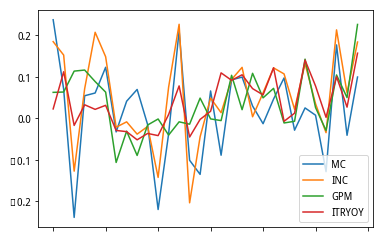

In [25]:
ic_res[0].T.plot()

In [26]:
#计算IC的各个指标
def cal_IC_indicator(data):
    '''
    input:
    data:dataframe,index为因子，columns为日期
    output:
    res:dataframe，index为因子，输出计算好的各个评判标准
    '''
    data = data.stack().unstack(0)
    data_mean = data.mean()
    data_std = data.std()
    data_ir = data_mean / data_std
    
    data_mean_df = data_mean.to_frame()
    data_mean_df.columns = ['mean']
    data_std_df = data_std.to_frame()
    data_std_df.columns = ['std']
    data_ir_df = data_ir.to_frame()
    data_ir_df.columns = ['IR']
    
    data_nagative = (data[data > 0]).count() / len(data)
    data_nagative_df = data_nagative.to_frame()
    data_nagative_df.columns = ['IC正值比例']
    data_abs_dayu = (data[data.abs() > 0.02]).count() / len(data)
    data_abs_dayu_df = data_abs_dayu.to_frame()
    data_abs_dayu_df.columns = ['IC绝对值>0.02']
    res = pd.concat([data_mean_df,data_std_df,data_nagative_df,data_abs_dayu_df,data_ir_df],axis=1)
    return res    
    

In [27]:
ic_indicator_pearson = cal_IC_indicator(ic_res[0])

In [29]:
ic_indicator_pearson

,mean,std,IC正值比例,IC绝对值>0.02,IR
MC,0.017524,0.112317,0.600000,0.900000,0.156024
INC,0.054747,0.107678,0.700000,0.866667,0.508437
GPM,0.036510,0.071470,0.566667,0.733333,0.510848
ITRYOY,0.037730,0.060202,0.700000,0.766667,0.626727


# 分层选股检验   5分类 

## 定义因子分组函数

In [105]:
def get_facor_return_rank(factor_name, types, fund_profit_data):
    """
    factor_name:  因子名称
    types: 种类  分类数量
    fund_profit_data: 因子收益数据 dict 类型， key 为日期， value 为DataFrame
    
    return: 返回字典， key为因子名称， value为list， 对应每月的因子收益（分组股票的平均收益）
    """
    dates = fund_profit_data.keys()
    returns_dict = {i:[] for i in range(types)}
    
    for date in dates:
        data = fund_profit_data[date].loc[:, [factor_name, "profit"]]
        data.sort_values(factor_name, inplace=True, ascending=False)
    
        last_value = data[factor_name].iloc[0]
        
        for i in range(types):
            length = int(len(data)/types) * (i+1)
            length = min(length-1, len(data)-1)
            value = data[factor_name].iloc[length] 
            tmp1 = data[(data[factor_name]>value) & (last_value>=data[factor_name])]
            returns_dict[i].append(tmp1.profit.mean())
            last_value = value
    return returns_dict

## 对因子进行遍历分组

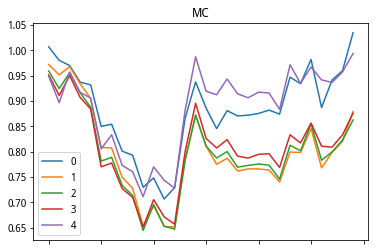

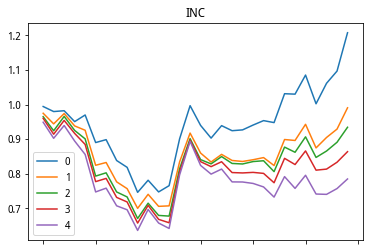

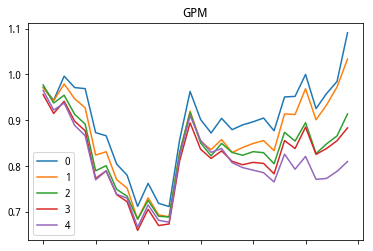

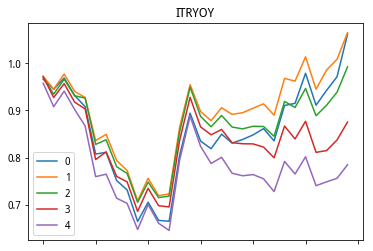

In [103]:
for factor_name in factor_list:
    returns = get_facor_return_rank(factor_name, 5, fund_profit_data)
    returns = pd.DataFrame(returns, index = fund_profit_data.keys())
    returns = (returns + 1).cumprod()
    returns.plot(title=factor_name)
